# Minimal AI Feature API Rollup Example
This notebook is intended as a bare bones example to show a straightforward case of:

* Pulling a result from the AI Feature API
* Loading the json payload into a GeoDataFrame
* Visualising the result


In [1]:
from pathlib import Path
import os
import json
import sys

import pandas as pd
import geopandas as gpd
import shapely.wkt

sys.path.append("../")
from nmaipy.feature_api import FeatureApi
from nmaipy import constants, log, parcels

# Path to local API response cache
CACHE_DIR = Path("./cache")

pd.set_option("display.max_rows", 1000)

In [2]:
# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

In [3]:
# Create instance of feature API to use existing python library
feature_api = FeatureApi(
    api_key=API_KEY,
    cache_dir=CACHE_DIR,
    alpha=True,
    beta=True,
    prerelease=True,
    parcelMode=True,
    system_version_prefix="gen6-",
    bulk_mode=False,

)

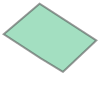

POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))


In [4]:
# Load a parcel boundary from test files
polygon = parcels.read_from_file(Path("../tests/data/test_parcels_2.csv")).iloc[5].geometry
display(polygon)
print(polygon)

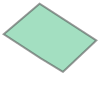

In [5]:
# Alternatively load your own boundary here
polygon = shapely.wkt.loads(
    "POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))"
)
polygon

In [6]:
# Get the API payload for that polygon as a geodataframe
features_gdf, metadata_df, error_df = feature_api.get_features_gdf(
    polygon,
    until="2024-06-20",
    region="us",
)

if error_df is not None:
    display(error_df)

In [7]:
metadata_df

{'system_version': 'gen6-glowing_lantern-1.0',
 'link': 'https://apps.nearmap.com/maps/#/@40.6278218,-74.2767828,20.00z,0d/V/20240620?locationMarker',
 'date': '2024-06-20',
 'survey_id': '8d974166-3981-11ef-8a98-bf7c3ea55d9b',
 'survey_resource_id': '39234a46-877b-58fd-a4db-da0523de13c7',
 'perspective': 'Vert',
 'postcat': False}

Total number of features returned: 44


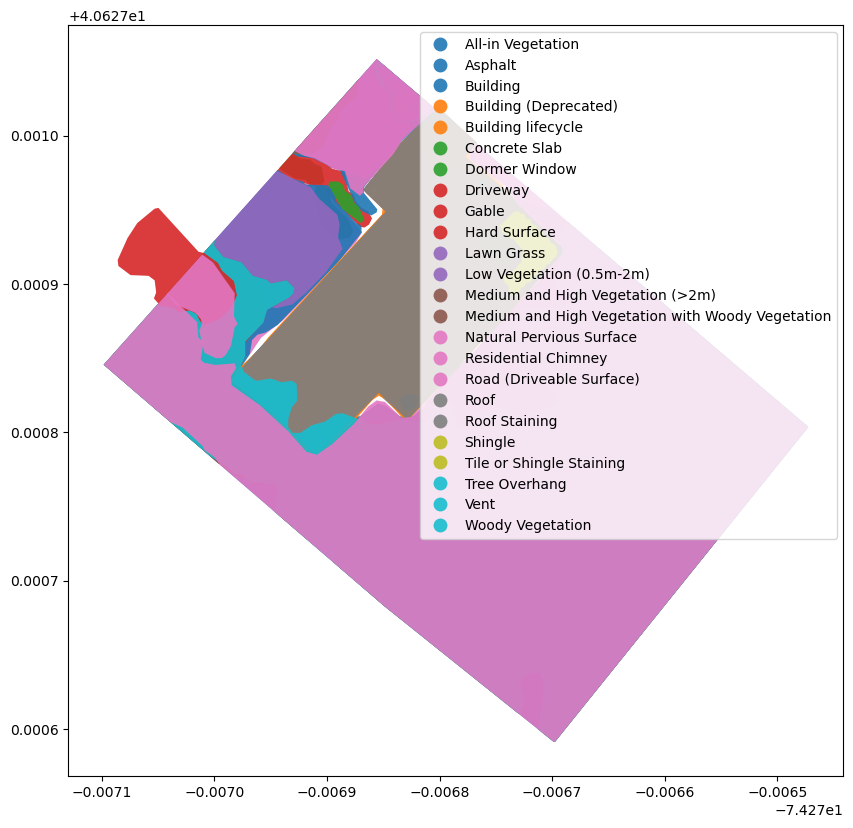

In [8]:
# Simple plot of features
features_gdf.plot("description", legend=True, figsize=(10, 10), alpha=0.9)

# Print the total number of features returned
print(f"Total number of features returned: {len(features_gdf)}")

In [10]:
import logging

logging.root.setLevel(logging.DEBUG)
polygon = shapely.wkt.loads(
    "POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))"
)

# Create a comparison instance without parcelMode 
feature_api_no_parcel_mode = FeatureApi(
    api_key=API_KEY,
    cache_dir=CACHE_DIR,
    alpha=True,
    beta=True,
    prerelease=True,
    parcelMode=False,
    system_version_prefix="gen6-",
)

# Get features with parcelMode=False for comparison
features_no_parcel_mode_gdf, metadata_no_parcel_mode_df, error_no_parcel_mode_df = feature_api_no_parcel_mode.get_features_gdf(
    polygon,
    until="2024-06-20",
    region="us",
)
assert error_no_parcel_mode_df is None

print(f"\nComparison of results:")
print(f"With parcelMode=True: {len(features_gdf)} features")
print(f"With parcelMode=False: {len(features_no_parcel_mode_gdf)} features")


Comparison of results:
With parcelMode=True: 44 features
With parcelMode=False: 58 features


In [11]:
import logging

logging.root.setLevel(logging.DEBUG)
polygon = shapely.wkt.loads(
    "POLYGON ((-74.27669919318933 40.62759165649627, -74.27684942918067 40.62768297885442, -74.27709829841933 40.62784547600499, -74.27685577334728 40.6280515391464, -74.27647245210946 40.62780346829123, -74.27669755653214 40.62759114461118, -74.27669919318933 40.62759165649627))"
)

# Create a comparison instance without parcelMode 
feature_api_no_parcel_mode = FeatureApi(
    api_key=API_KEY,
    cache_dir=CACHE_DIR,
    alpha=True,
    beta=True,
    prerelease=True,
    parcelMode=False,
    system_version_prefix="gen6-",
)

# Get features with parcelMode=False for comparison
features_no_parcel_mode_gdf, metadata_no_parcel_mode_df, error_no_parcel_mode_df = feature_api_no_parcel_mode.get_features_gdf(
    polygon,
    until="2024-06-20",
    region="us",
)
assert error_no_parcel_mode_df is None

print(f"\nComparison of results:")
print(f"With parcelMode=True: {len(features_gdf)} features")
print(f"With parcelMode=False: {len(features_no_parcel_mode_gdf)} features")


Comparison of results:
With parcelMode=True: 44 features
With parcelMode=False: 58 features


In [12]:
# Filter out edge features based on default logic (ratios in parcel and minimum clipped areas)
parcel_gdf = gpd.GeoDataFrame(
    {"geometry": [polygon], "aoi_id": 0},
    crs="EPSG:4326",
)

# Filter features with parcelMode=False to compare with API's parcelMode=True filtering
filtered_features_gdf = parcels.filter_features_in_parcels(
    features_no_parcel_mode_gdf.assign(aoi_id=0).set_index("aoi_id"), aoi_gdf=parcel_gdf, region="us"
)

print(f"\nFeatures after nmaipy filtering: {len(filtered_features_gdf)} features")
print(f"API parcelMode=True filtering: {len(features_gdf)} features")
print(f"Raw API response without parcelMode: {len(features_no_parcel_mode_gdf)} features")


Features after nmaipy filtering: 49 features
API parcelMode=True filtering: 44 features
Raw API response without parcelMode: 58 features


In [13]:
filtered_features_gdf

,feature_id,class_id,internal_class_id,description,confidence,parent_id,geometry,area_sqm,area_sqft,clipped_area_sqm,...,unclipped_area_sqft,attributes,survey_date,mesh_date,class_status,fidelity,belongs_to_parcel,intersection_ratio,building_small,building_multiparcel
aoi_id,,,,,,,,,,,,,,,,,,,,,
0,05b33934-2f87-5be3-af8a-b1432c25ac34,2780fa70-7713-437c-ad98-656b8a5cc4f2,1026,Low Vegetation (0.5m-2m),0.57,,"POLYGON ((-74.27691 40.62796, -74.2769 40.6279...",2.500000,27.0,2.5,...,2.700000e+01,[],2024-06-20,,prod,NaN,None,1.000000e+00,NaN,NaN
0,08a5955a-b030-5200-944b-63deb3fcfbd9,cfa8951a-4c29-54de-ae98-e5f804c305e3,1053,Tile or Shingle Staining,0.55,ca7e1039-f856-50a7-b5c5-c552c480f8cb,"POLYGON ((-74.27683 40.62781, -74.27683 40.627...",0.801552,9.0,0.8,...,9.000000e+00,[],2024-06-20,,prod,NaN,None,1.000000e+00,NaN,NaN
0,0e7e6b14-cb27-54b6-bdd2-d99b5a092cc0,319f552f-f4b7-520d-9b16-c8abb394b043,1144,Roof Staining,0.62,ca7e1039-f856-50a7-b5c5-c552c480f8cb,"POLYGON ((-74.27688 40.62783, -74.27688 40.627...",7.497719,81.0,7.5,...,8.100000e+01,[],2024-06-20,,prod,NaN,None,1.000000e+00,NaN,NaN
0,1084c77a-30d0-56c7-a328-53543b455233,f4b78dad-c2c0-5236-8eb1-3266ed468604,1072,Natural Pervious Surface,0.96,,"POLYGON ((-74.27693 40.62797, -74.2769 40.6279...",81.500000,878.0,81.5,...,1.249000e+03,[],2024-06-20,,prod,NaN,None,7.019811e-01,NaN,NaN
0,10f05f4c-459e-5278-a522-d94598e6a939,319f552f-f4b7-520d-9b16-c8abb394b043,1144,Roof Staining,0.74,ca7e1039-f856-50a7-b5c5-c552c480f8cb,"POLYGON ((-74.27681 40.62795, -74.2768 40.6279...",74.799063,805.0,74.7,...,8.050000e+02,[],2024-06-20,,prod,NaN,None,9.986631e-01,NaN,NaN
0,11c349db-42ac-52fb-a220-4da1df67a516,eaa83113-44b3-505e-9515-ba8a8d403dd4,1107,Woody Vegetation,0.63,,"POLYGON ((-74.2769 40.62796, -74.2769 40.62795...",6.100000,65.0,6.1,...,6.500000e+01,[],2024-06-20,,prod,NaN,None,1.000000e+00,NaN,NaN
0,11e34e33-2c61-5f61-a6ce-32d25c71d11d,c54e38d6-866f-592c-bb9c-c68044ed43c9,1055,Residential Chimney,0.87,ca7e1039-f856-50a7-b5c5-c552c480f8cb,"POLYGON ((-74.27681 40.62787, -74.27681 40.627...",1.043620,11.0,1.0,...,1.100000e+01,[],2024-06-20,,prod,NaN,None,1.000000e+00,NaN,NaN
0,12392e05-e0b8-5e00-af29-f30bd4dd8d58,290897be-078b-4948-97aa-755289a67a29,1031,Concrete Slab,0.55,,"POLYGON ((-74.27691 40.62798, -74.2769 40.6279...",4.500000,49.0,4.5,...,8.200000e+01,[],2024-06-20,,prod,NaN,None,5.921053e-01,NaN,NaN
0,14f04fe5-11db-5f18-9c0b-7f0a35a60b26,cfa8951a-4c29-54de-ae98-e5f804c305e3,1053,Tile or Shingle Staining,0.61,ca7e1039-f856-50a7-b5c5-c552c480f8cb,"POLYGON ((-74.27682 40.62795, -74.27682 40.627...",29.798422,321.0,29.8,...,3.210000e+02,[],2024-06-20,,prod,NaN,None,1.000000e+00,NaN,NaN


# Create parcel rollup

Once we have the features in a parcel, all that remains is to flatten the features and attributes to tabular format. Note that roof and building values relate to the primary building and roof within a parcel. The primary building is defined as the building with the largest area within the parcel.

We'll compare rollups generated with and without parcelMode to see the differences.

In [14]:
df_classes = pd.DataFrame([{"description": "Roof"}], index=[constants.ROOF_ID])
df_classes

,description
c08255a4-ba9f-562b-932c-ff76f2faeeeb,Roof


In [15]:
rollup = parcels.feature_attributes(
    filtered_features_gdf, df_classes, "us", "largest_intersection", primary_decision="largest_intersection"
)
rollup

{'roof_present': 'Y',
 'roof_count': 1,
 'roof_total_area_sqft': np.float64(3115.0),
 'roof_total_clipped_area_sqft': np.float64(3103.0),
 'roof_total_unclipped_area_sqft': np.float64(3115.0),
 'roof_confidence': np.float64(0.99),
 'roof_small_count': 0,
 'roof_multiparcel_count': 0,
 'primary_roof_area_sqft': np.float64(3115.0),
 'primary_roof_clipped_area_sqft': np.float64(3103.0),
 'primary_roof_unclipped_area_sqft': np.float64(3115.0),
 'primary_roof_confidence': np.float64(0.99),
 'primary_roof_fidelity': np.float64(0.95869493),
 'primary_roof_small': False,
 'primary_roof_multiparcel': False,
 'primary_roof_tile_present': 'N',
 'primary_roof_tile_area_sqft': 0,
 'primary_roof_tile_confidence': None,
 'primary_roof_tile_dominant': 'N',
 'primary_roof_shingle_present': 'Y',
 'primary_roof_shingle_area_sqft': 3109,
 'primary_roof_shingle_confidence': 0.9980469,
 'primary_roof_shingle_dominant': 'Y',
 'primary_roof_metal_present': 'N',
 'primary_roof_metal_area_sqft': 0,
 'primary_ro